In [354]:
import cv2
import numpy as np

from skimage import io
from skimage.filters import unsharp_mask, threhsold_otsu
from skimage.color import rgb2gray

In [321]:
from skimage.measure import label, regionprops

from skimage.morphology import *

In [152]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [188]:
def otsu_image(image, threshold=0):
    gray = 1 - image
    threshold = threshold_otsu(gray)

    return gray > threshold

In [544]:
def find_coords_column(img, nb_colums=-1, spacing_threshold=20, line_samples=1000):
    img_part = img[:line_samples,:]
    scores = img_part.sum(axis=0)
    sort_indices = np.argsort(scores)[::-1]

    x_coords = []
    for indice in sort_indices:
        interrupted = False
        for x in x_coords:
            if abs(indice - x) < spacing_threshold:
                interrupted = True
                break
        if not interrupted:
            x_coords.append(indice)
            if len(x_coords) == nb_colums:
                break
    return sorted(x_coords)


def find_coords_row(img, nb_colums=-1, spacing_threshold=20, line_samples=1000):
    img_part = img[:,:line_samples]
    scores = img_part.sum(axis=1)
    sort_indices = np.argsort(scores)[::-1]

    y_coords = []
    for indice in sort_indices:
        interrupted = False
        for y in y_coords:
            if abs(indice - y) < spacing_threshold:
                interrupted = True
                break
        if not interrupted:
            y_coords.append(indice)
            if len(y_coords) == nb_colums:
                break
    return sorted(y_coords)

In [218]:
def filter_bad_lines(img, threshold=0.1):
    label_image = label(img)

    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        ratio = min(h, w) / max(h, w)
        box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        if ratio > threshold:
            sm = img[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            continue

    return img

In [533]:
def line_seems_valid(image, rr, cc):
    mask = np.zeros(image.shape)
    mask[rr, cc] = 255
    mask = mask > 0

    black_count = np.sum(image[mask] < 0.7)
    total_count = np.sum(mask)
    
    return black_count / total_count > 0.4

In [633]:
def learn(X, y, pol_degree):
    try:
        model = Pipeline([('poly', PolynomialFeatures(degree=pol_degree)),
                          ('linear', RANSACRegressor())])
        model.fit(X, y)
    except:
        model = Pipeline([('poly', PolynomialFeatures(degree=pol_degree)),
                          ('linear', LinearRegression())])
        model.fit(X, y)

    return model

In [602]:
def curvature(original, rr, cc):
    mask = np.zeros(original.shape)
    mask[rr, cc] = 255
    mask = mask > 0

    black_count = np.sum(original[mask] < 0.7)
    total_count = np.sum(mask)

    return total_count / black_count


def curvature_filter(original, arr, spacing_threshold=200):
    arr = list(arr)

    cvts = np.array([curvature(original, rr, cc) for _, rr, cc in arr])
    result = []

    known_pos = []

    for i in np.argsort(cvts):
        pos, rr, cc = arr[i]

        if np.sum(np.abs(known_pos - pos) < spacing_threshold) > 0:
            continue

        known_pos = np.append(known_pos, [pos])
        result.append([rr, cc])

    return np.array(result)[np.argsort(known_pos)]

In [603]:
def get_columns(original, img, context_width=50, pol_degree=3):
    for column in find_coords_column(img):
        m_x = max(0, column - context_width)
        pix = img[:,m_x:column+context_width]

        non_z = cv2.findNonZero(pix * 255)

        if non_z is None or non_z.shape[0] < 50:
            continue

        non_z = non_z.reshape(-1, 2)
        model = learn(non_z[:,1].reshape(-1, 1), non_z[:,0], pol_degree)

        rr = np.array([i for i in range(img.shape[0])]).astype(np.int32)
        cc = model.predict(rr.reshape(-1, 1)).astype(np.int32) + m_x

        cc[cc < 0] = 0
        cc[cc >= original.shape[1]] = original.shape[1] - 1

        if line_seems_valid(original, rr, cc):
            yield (column, rr, cc)


def get_rows(original, img, context_width=50, pol_degree=3):
    for row in find_coords_row(img):
        m_y = max(0, row - context_width)
        pix = img[m_y:row+context_width,:]

        non_z = cv2.findNonZero(pix * 255)

        if non_z is None or non_z.shape[0] < 50:
            continue

        non_z = non_z.reshape(-1, 2)

        model = learn(non_z[:,0].reshape(-1, 1), non_z[:,1], pol_degree)

        cc = np.array([i for i in range(img.shape[1])]).astype(np.int32)
        rr = model.predict(cc.reshape(-1, 1)).astype(np.int32) + m_y

        rr[rr < 0] = 0
        rr[rr >= original.shape[0]] = original.shape[0] - 1

        if line_seems_valid(original, rr, cc):
            yield (row, rr, cc)

In [604]:
def prefilter(image):
    img = otsu_image(image)
    img = img ^ ((img ^ remove_small_objects(img, 50000)) | (remove_small_objects(img, 1000000)))
    img = binary_dilation(filter_bad_lines(img, threshold=0.3))

    filtred_img = image.copy()
    filtred_img[img] = 1

    filtred_img = unsharp_mask(filtred_img, radius=5, amount=3)
    c = 50

    lin_img = filter_bad_lines(dilation(filtred_img, np.array([[1]*c])) < 0.7)
    lin_img = filter_bad_lines(closing(lin_img, square(10)))

    col_img = filter_bad_lines(dilation(filtred_img, np.array([[1]]*c)) < 0.7)
    col_img = filter_bad_lines(closing(col_img, square(10)))

    return lin_img, col_img

In [631]:
def process_image(inputFile, exteriorFile, gridFile):
    image = rgb2gray(io.imread(inputFile))
    lin_img, col_img = prefilter(image)

    cols = list(curvature_filter(image, get_columns(image, col_img)))
    rows = list(curvature_filter(image, get_rows(image, lin_img)))

    # external border masks
    borders = np.zeros(image.shape)

    for rr, cc in [cols[0], cols[-1], rows[0], rows[-1]]:
        borders[rr, cc] = 255

    # exterior mask
    exterior = borders.copy()
    exterior = remove_small_holes(exterior > 0, 5000000)*255 - borders
    exterior = binary_closing(exterior > 0) * 255

    # internal grid mask
    grid = np.zeros(image.shape)

    for rr, cc in (cols[1:-1] + rows[1:-1]):
        grid[rr, cc] = 255

    grid = dilation(grid, disk(2))
    grid[exterior == 255] = 0

    io.imsave(exteriorFile, exterior.astype(np.uint8))
    io.imsave(gridFile, grid.astype(np.uint8))

In [632]:
process_image(FILES[0], "pikou.png", "pikou2.png")

<ipython-input-631-1940270272ca>:29: UserWarning: pikoukou.png is a low contrast image
  io.imsave(gridFile, grid.astype(np.uint8))


In [596]:
FILES = !ls inputs/*

for i, f in enumerate(FILES):
    process_image(f, f"pikou{i}.png")

/usr/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/usr/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/usr/lib/python3.8/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Un

In [577]:
FILES = !ls inputs/*
image = rgb2gray(io.imread(FILES[1]))

In [578]:
lin_img, col_img = prefilter(image)

In [592]:
cols = list(curvature_filter(image, get_columns(image, col_img)))
rows = list(curvature_filter(image, get_rows(image, lin_img)))

In [589]:
result = np.zeros(image.shape)

for rr, cc in (cols + rows):
    result[rr, cc] = 255

result = dilation(result, disk(2))

In [590]:
img2 = image.copy()
img2[result > 128] = 1
io.imsave("pikou.png", img2)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


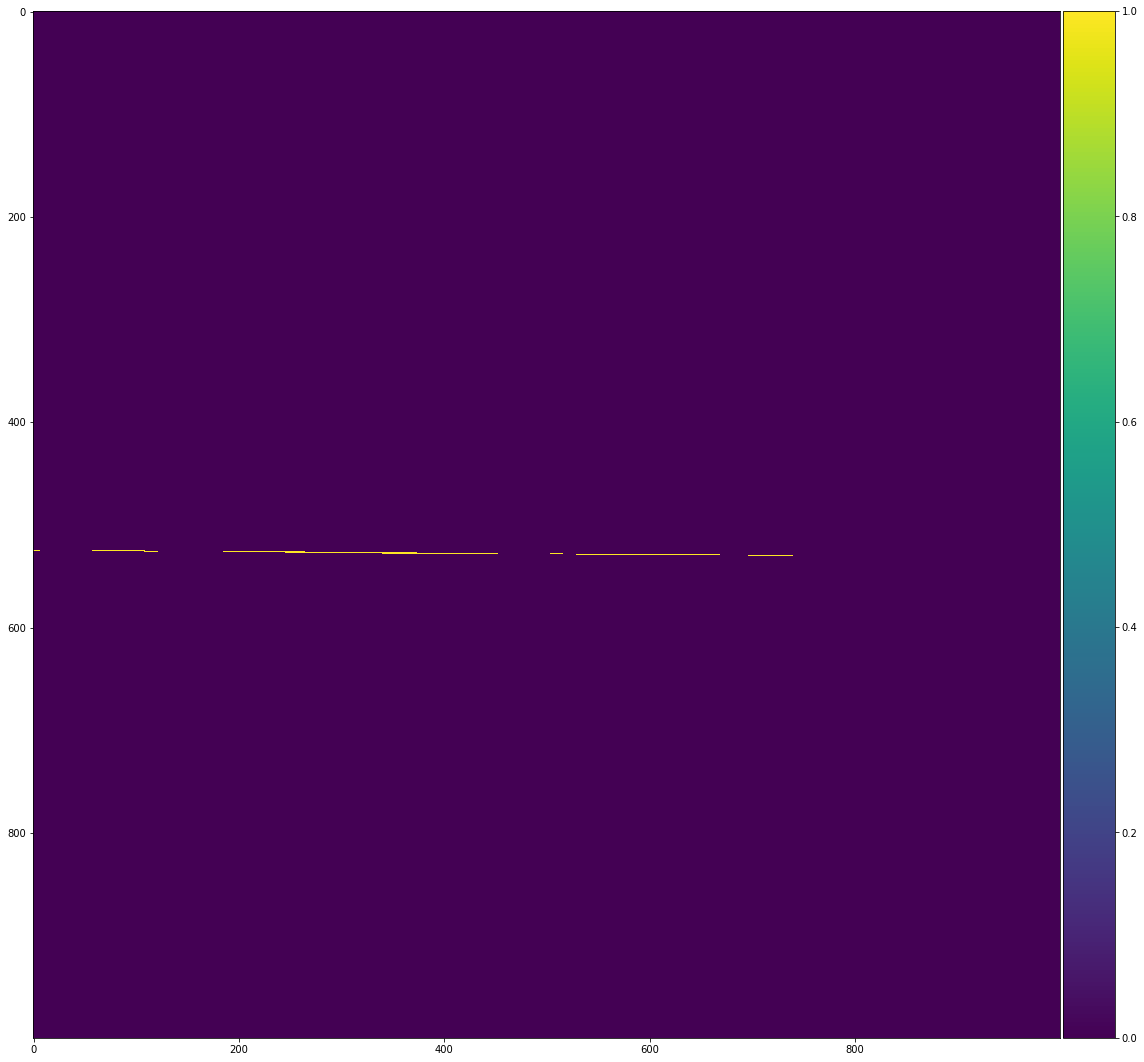

In [553]:
plt.figure(figsize=(16,16))
io.imshow(lin_img[:1000,-1000:])